In [1]:
%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_create
import functions as fct
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd


c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
#choose country
country = 882

#number of simulated years
r = 10000

#define maximum and minimum return periods to be covered
lower_share = 0.05
upper_rp = 250

target_sharpe = 0.5
rf_rate = 0.0

cc_models = ["CMCC", "CNRM", "ECEARTH", "HADGEM"]

OUTPUR_DIR = Path("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/hazard")
STORM_DIR = Path("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/hazard/tc_tracks/storm_tc_tracks/climate_change")

In [3]:
bond_metrics_dic = {}
bond_returns_dic = {}
premium_dic_dic = {}
nominal_dic = {}
pay_dam_df_dic = {}
es_metrics_dic = {}
int_grid_dic = {}
imp_per_event_flt_dic = {}
imp_admin_evt_flt_dic = {}
ann_losses_dic = {}

bond_metrics_dic['CRCL'], bond_returns_dic['CRCL'], premium_dic_dic['CRCL'], nominal_dic['CRCL'], pay_dam_df_dic['CRCL'], es_metrics_dic['CRCL'], int_grid_dic['CRCL'], imp_per_event_flt_dic['CRCL'], imp_admin_evt_flt_dic['CRCL'], ann_losses_dic['CRCL'] = bond_create.sng_cty_bond(country, grid_specs=[5,5], grid_size=1000, 
                                                                                                                                                                                                                                                                                        prot_rp=upper_rp, to_prot_share=lower_share)

for mod in cc_models:
    bond_metrics, bond_returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt, ann_losses = bond_create.sng_cty_bond_cc(country, cc_model=mod, grid_specs=[5,5], grid_size=1000, 
                                                                                                                                                                       prot_rp=250, to_prot_share=lower_share, 
                                                                                                                                                                       output_dir=OUTPUR_DIR, storm_dir=STORM_DIR)

    bond_metrics_dic[mod] = bond_metrics
    bond_returns_dic[mod] = bond_returns
    premium_dic_dic[mod] = premium_dic
    nominal_dic[mod] = nominal
    pay_dam_df_dic[mod] = pay_dam_df
    es_metrics_dic[mod] = es_metrics
    int_grid_dic[mod] = int_grid
    imp_per_event_flt_dic[mod] = imp_per_event_flt
    imp_admin_evt_flt_dic[mod] = imp_admin_evt_flt
    ann_losses_dic[mod] = ann_losses


Number of tracks in SP basin: 3002
The principal of the cat bond is: 316652842.906 [USD]
Principal as share of GDP: 0.364
Number of tracks in SP basin: 2708
The principal of the cat bond is: 409000766.432 [USD]
Principal as share of GDP: 0.471
Number of tracks in SP basin: 4133
The principal of the cat bond is: 377844287.308 [USD]
Principal as share of GDP: 0.435
Number of tracks in SP basin: 3188
The principal of the cat bond is: 437698643.195 [USD]
Principal as share of GDP: 0.504
Number of tracks in SP basin: 2718
The principal of the cat bond is: 439081824.298 [USD]
Principal as share of GDP: 0.505


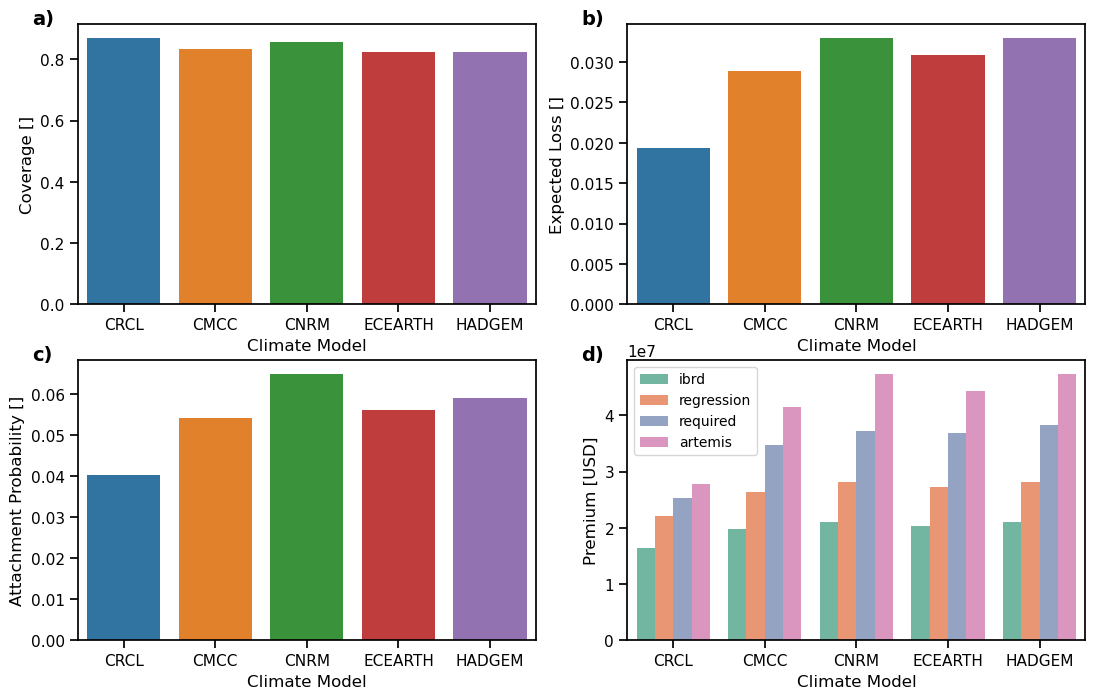

In [16]:
tc_sets = ["CRCL", "CMCC", "CNRM", "ECEARTH", "HADGEM"]
tc_sets_rep = [item for item in tc_sets for _ in range(4)]
cc_cond = ["Present Climate", "Climate Change", "Climate Change", "Climate Change", "Climate Change"]

cc_coverage = []
prem_data = []
cc_exp_loss = []
cc__att_prob = []
for i, mod in enumerate(tc_sets):
    cc_coverage.append(bond_metrics_dic[mod]['Coverage'][0])
    cc_exp_loss.append(premium_dic_dic[mod]['exp_loss'])
    cc__att_prob.append(premium_dic_dic[mod]['att_prob'])
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "ibrd", "Premium [USD]": premium_dic_dic[mod]['ibrd'] * nominal_dic[mod]})
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "regression", "Premium [USD]": premium_dic_dic[mod]['regression'] * nominal_dic[mod]})
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "required", "Premium [USD]": premium_dic_dic[mod]['required'] * nominal_dic[mod]})
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "artemis", "Premium [USD]": premium_dic_dic[mod]['artemis'] * nominal_dic[mod]})

cc_coverage = np.array(cc_coverage).flatten()
cc_exp_loss = np.array(cc_exp_loss).flatten()
cc__att_prob = np.array(cc__att_prob).flatten()
prem_data = pd.DataFrame(prem_data)
prem_data['Climate Model'] = tc_sets_rep

df_coverage = {'Coverage []': cc_coverage, 'Climate Condition': cc_cond, 'Climate Model': tc_sets}
df_exp_loss = {'Expected Loss []': cc_exp_loss, 'Climate Condition': cc_cond, 'Climate Model': tc_sets}
df_att_prob = {'Attachment Probability []': cc__att_prob, 'Climate Condition': cc_cond, 'Climate Model': tc_sets}

fig, axes = plt.subplots(2, 2, figsize=(13, 8))
ax1, ax2, ax3, ax4 = axes.ravel() 
marker_types = ['o','s', '^']
#sns.set_context("notebook", font_scale=1)
sns.barplot(y='Coverage []', x='Climate Model', data=df_coverage, ax=ax1, hue='Climate Model', legend=False)
sns.barplot(y='Expected Loss []', x='Climate Model', data=df_exp_loss, ax=ax2, hue='Climate Model', legend=False)
sns.barplot(y='Attachment Probability []', x='Climate Model', data=df_att_prob, ax=ax3, hue='Climate Model', legend=False)
palette = sns.color_palette("Set2", n_colors=prem_data['Premium Type'].nunique())
sns.barplot(y='Premium [USD]', x='Climate Model', data=prem_data, ax=ax4, hue='Premium Type', palette=palette)

panel_labels = ["a)", "b)", "c)", "d)"]
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.annotate(panel_labels[i], 
                xy=(-0.1, 1),  # Position: top-left corner
                xycoords="axes fraction",  # Relative to axes
                fontsize=14, 
                fontweight="bold")
    
ax4.legend(fontsize=10)

In [5]:
print(df_coverage['Coverage []'][0], min(df_coverage['Coverage []'][1:]), max(df_coverage['Coverage []'][1:]))
print(df_exp_loss['Expected Loss []'][0], 
      min(df_exp_loss['Expected Loss []'][1:]), 
      max(df_exp_loss['Expected Loss []'][1:]))
print(df_att_prob['Attachment Probability []'][0], 
      min(df_att_prob['Attachment Probability []'][1:]), 
      max(df_att_prob['Attachment Probability []'][1:]))

0.8708174693953462 0.8226619327336564 0.8557752270233937
0.01931029506887575 0.028880027250377013 0.0330417707497268
0.0401787202827515 0.05411623487046114 0.06501950585175553


In [6]:
crcl_premiums = prem_data[prem_data['Climate Model'] == 'CRCL'][['Premium Type', 'Premium [USD]']]
crcl_premiums = crcl_premiums.rename(columns={'Premium [USD]': 'CRCL Premium'})

# Merge with other climate models' premiums
merged_data = prem_data[prem_data['Climate Model'] != 'CRCL'].merge(
    crcl_premiums,
    on='Premium Type',
    how='left'
)

# Calculate percentage change
merged_data['Percentage Change'] = (
    (merged_data['Premium [USD]'] - merged_data['CRCL Premium']) / merged_data['CRCL Premium'] * 100
)

# Group by Premium Type and aggregate min and max percentage change
result = merged_data.groupby('Premium Type')['Percentage Change'].agg(['min', 'max'])

print(result)

                    min        max
Premium Type                      
artemis       49.381101  70.907599
ibrd          19.606121  27.456914
regression    19.007623  27.325117
required      37.731642  52.014668


In [7]:
import exposures_cc as ex_cc
import exposures_alt as exa
tc_storms_dic = {}
for mod in cc_models:    
    exp, applicable_basin, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = ex_cc.init_TC_exp(country=country, cc_model=mod, grid_specs=[2,2], buffer_grid_size=105, buffer_distance_km=1, res_exp=30, min_pol_size=500, file_path=OUTPUR_DIR, storm_path=STORM_DIR, load_fls=True, plot_exp=False, plot_centrs=False, plt_grd=False)
    tc_storms_dic[mod] = tc_storms

exp, applicable_basins, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = exa.init_TC_exp(country, grid_specs=[2,2], buffer_distance_km=105, res_exp=30, min_pol_size=500, buffer_grid_size=1, load_fls=True, plot_exp=False, plot_centrs=False, plt_grd=False)
tc_storms_dic['CRCL'] = tc_storms

Number of tracks in SP basin: 2708
Number of tracks in SP basin: 4133
Number of tracks in SP basin: 3188
Number of tracks in SP basin: 2718
Number of tracks in SP basin: 3002


<Axes: xlabel='Tropical Cyclone Category', ylabel='Share per Category (%)'>

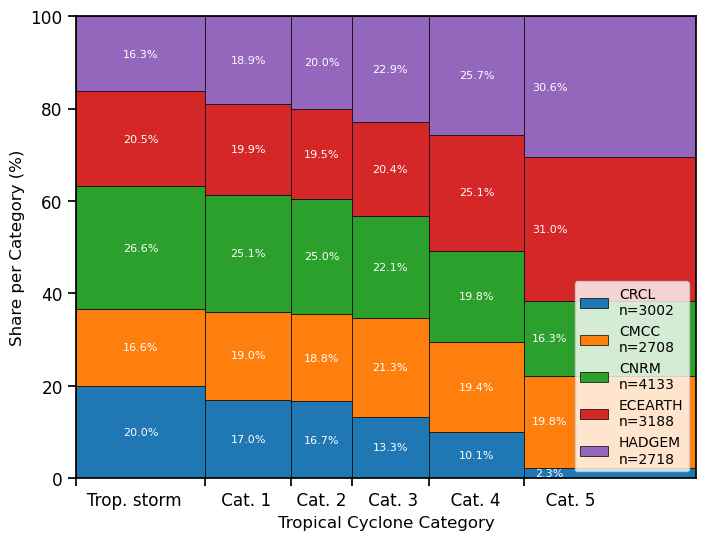

In [8]:
categories_plot = np.array([18, 33, 43, 50, 59, 70, 120]) #TC
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fct.plot_TC_hist_cc(tc_storms_dic, categories_plot, ax)